In [1]:
### things to fix

# - Notes about FTK:
#     - does better when B>1, need to add more shift testing
#     - but e.g. for 2's the shift doesn't help, (does improve base score for 6's)
#     - Fix FTK to match angular grid sampling
#     - Fix FTK to return the full correlation
# - Check that WEMD and POT are done correctly
# - improve sliced Wasserstein for addditive noise somehow?
# - sliced Volterra seems to do better under noise when using signed metric?

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

### my library

import images
import transforms
import distances
import utils

In [4]:
### extra helper functions (move plots to plot_utils later)

def square_tile_plot(images, l, s=5, p=0.3, cmap='gray', save_path=False, show=True):
    
    assert images.shape[0] >= l**2, "not enough images"
    
    fig, axs = plt.subplots(l, l, figsize=(s,s))
    axs = axs.flatten()
    
    for idx, ax in enumerate(axs):
        ax.imshow(images[idx], cmap=cmap)
        ax.axis('off')
        
    plt.tight_layout(h_pad=p, w_pad=p)
    
    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
        

def within_n_degrees(gt_rotations, est_rotations, n_deg):
    """number images within n_degrees of ground truth rotation"""
    angle_diffs = abs(gt_rotations - est_rotations)
    within_n = np.count_nonzero(angle_diffs <= n_deg) # want incluse so use leq and geq
    within_n += np.count_nonzero(angle_diffs >= 360-n_deg)
    percent_within_n_degrees = within_n / angle_diffs.size
    
    return percent_within_n_degrees

In [5]:
### prepare images
np.random.seed(0)

### load original mnist test set data
mnist_image_file = 'Data/t10k-images-idx3-ubyte.gz'
mnist_label_file = 'Data/t10k-labels-idx1-ubyte.gz'

mnist_images = utils.load_mnist_images(mnist_image_file)
mnist_labels = utils.load_mnist_labels(mnist_label_file)

### zero pad images to ensure bounded by disk
w = (64 - 28) // 2  # pad to nearest power of 2
mnist_images = utils.zero_pad_image_stack(mnist_images, w)

### separate images by digit
digit_images = {}
for digit in range(10):
    loc = np.argwhere(digit == mnist_labels).flatten()
    imgs = mnist_images[loc]
    digit_images[digit] = imgs
    
### pick a reference of each digit for alignment
ref_digits = {0: 1, 1: 5, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 3, 9: 2}  # selected representation of each digit
ref_images = {}
for digit, ref_idx in ref_digits.items():
    ref_img = digit_images[digit][ref_idx]
    ref_images[digit] = ref_img
    digit_images[digit] = np.delete(digit_images[digit], ref_idx, axis=0)  # remove reference from image stack
ref_images = np.array([ref_images[digit] for digit in range(10)])  # convert to array to simplify transforms
    
### select number of images for comparison (alternatively can randomly shuffle)
n_imgs = 100
for digit, imgs in digit_images.items():
    digit_images[digit] = imgs[:n_imgs]
    
### randomly rotate images of each digit (i.e. rotated mnist data)
rotations = np.random.randint(0, 360, n_imgs)  # use same distribution for each image
digit_images_rot = {}
for digit, imgs in digit_images.items():
    rot_imgs = []
    for idx, img in enumerate(imgs):
        rot_imgs.append(utils.rotate(img, rotations[idx]))
    digit_images_rot[digit] = np.array(rot_imgs)

In [6]:
### inputs and preprocess images
np.random.seed(0)

digit = 2
angles = np.linspace(0, 360, 64, endpoint=False)
# angles = np.arange(0, 360, 1)  # set angles to 1 deg increment instead of L
n_points = 64 
apply_shift = False
s = 4

### convert to image class and preprocess
refs = images.Image(ref_images, normalize=True, mask=True).preprocess_images()
ref_img = refs[digit]
imgs = digit_images_rot[digit]
imgs = images.Image(imgs, normalize=True, mask=True).preprocess_images()


if apply_shift:
    
    shifts = np.random.choice((-s, s), (n_imgs, 2))  # generate random shifts in {-s, s}

    for idx, shift in enumerate(shifts):
        ty, tx = shift
        imgs[idx] = utils.translate(imgs[idx], ty, tx)

In [7]:
### compute distances

### sliced Wasserstein distance
t = time.time()
refs_pos, refs_neg = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
imgs_pos, imgs_neg = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()

dists_dict_sw = distances.reference_rotational_distances(refs_pos[digit], imgs_pos, n_points)
# dists_dict_sw = distances.signed_reference_rotational_distances(refs_pos[digit], imgs_pos, refs_neg[digit], imgs_neg, n_points)
angles_est_sw = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_sw.items()])
print('SW runtime: ', time.time() - t)


### sliced Volterra distance
t = time.time()
refs_pos, refs_neg = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_cdf_transform()
imgs_pos, imgs_neg = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_cdf_transform()

dists_dict_sv = distances.reference_rotational_distances(refs_pos[digit], imgs_pos, n_points)
# dists_dict_sv = distances.signed_reference_rotational_distances(refs_pos[digit], imgs_pos, refs_neg[digit], imgs_neg, n_points)
angles_est_sv = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_sv.items()])
print('SV runtime: ', time.time() - t)


### Euclidean distance (Fourier)
t = time.time()
refs_t = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).polar_nufft()
imgs_t = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).polar_nufft()

dists_dict_l2 = distances.reference_rotational_distances(refs_t[digit], imgs_t, n_points)
angles_est_l2 = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_l2.items()])
print('L2 runtime: ', time.time() - t)


### Brute force rotations
t = time.time()
dists_dict_bf = {idx: distances.real_space_rotational_distance(ref_img, imgs[idx], angles) for idx in range(n_imgs)}
angles_est_bf = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_bf.items()])
print('BF runtime: ', time.time() - t)


### FTK 
t = time.time()
corr_ftk, angles_est_ftk, shift_est_ftk = distances.ftk_align(ref_img, imgs, B=1)
angles_est_ftk = 360 - angles_est_ftk  # not sure why I need this
print('FTK runtime: ', time.time() - t)


### Wavelet EMD 
t = time.time()
dists_dict_wemd = {idx: distances.wemd_rotational_distance(ref_img, imgs[idx], angles, wavelet='sym3', level=3) for idx in range(n_imgs)}
angles_est_wemd = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_wemd.items()])
print('WEMD runtime: ', time.time() - t)


### Wasserstein 2
t = time.time()
M = compute_transport_matrix(imgs[0])
dists_dict_w2 = {idx: rotational_wasserstein_distance(ref_img, imgs[idx], angles, M) for idx in range(n_imgs)}
angles_est_w2 = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_w2.items()])
print('W2 runtime: ', time.time() - t)

SW runtime:  0.29874396324157715
SV runtime:  0.24365663528442383
L2 runtime:  0.23141002655029297
BF runtime:  3.186636447906494
FTK runtime:  1.7253384590148926
WEMD runtime:  4.995592355728149
W2 runtime:  1182.0172548294067


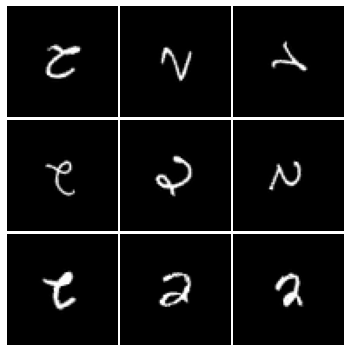

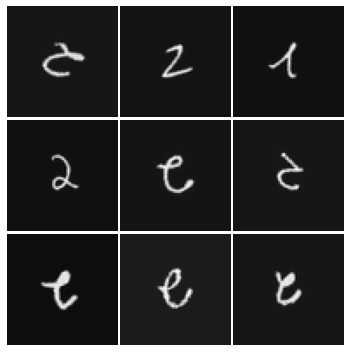

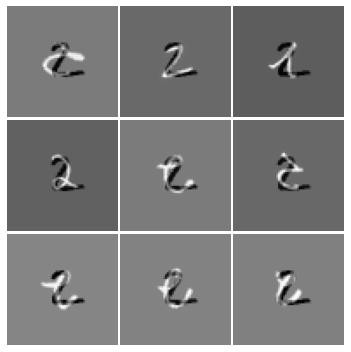

In [8]:
### *** Add vmin, vmax to make everythin on the same scale??

### for plotting
aligned_imgs = np.array([utils.rotate(img, -angles_est_bf[idx]) for idx, img in enumerate(imgs)])
diff_maps = aligned_imgs - ref_img

# imgs_save_path = 'Output/mnist_output/digit_9_imgs.pdf'
# diff_save_path = 'Output/mnist_output/digit_9_diff.pdf'

square_tile_plot(imgs, 3)
square_tile_plot(aligned_imgs, 3)
square_tile_plot(diff_maps, 3)

In [9]:
n_deg_tol = 181

percents_sw = np.zeros(n_deg_tol)
percents_sv = np.zeros(n_deg_tol)
percents_l2 = np.zeros(n_deg_tol)
percents_bf = np.zeros(n_deg_tol)
percents_ftk = np.zeros(n_deg_tol)
percents_wemd = np.zeros(n_deg_tol)
percents_w2 = np.zeros(n_deg_tol)

for n_deg in range(n_deg_tol):
    percents_sw[n_deg] = within_n_degrees(rotations, angles_est_sw, n_deg)
    percents_sv[n_deg] = within_n_degrees(rotations, angles_est_sv, n_deg)
    percents_l2[n_deg] = within_n_degrees(rotations, angles_est_l2, n_deg)
    percents_bf[n_deg] = within_n_degrees(rotations, angles_est_bf, n_deg)
    percents_ftk[n_deg] = within_n_degrees(rotations, angles_est_ftk, n_deg)
    percents_wemd[n_deg] = within_n_degrees(rotations, angles_est_wemd, n_deg)
    percents_w2[n_deg] = within_n_degrees(rotations, angles_est_w2, n_deg)

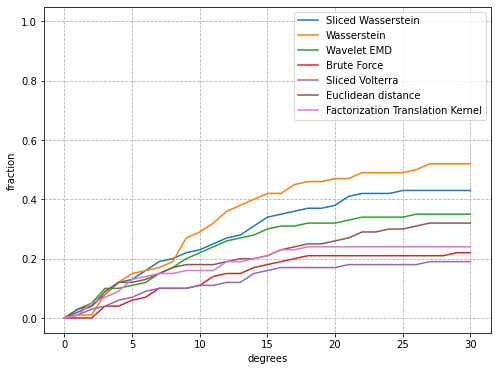

In [15]:
### *** Add titles!

plt.figure(figsize=(8,6))
plt.plot(percents_sw[:31], '-', label='Sliced Wasserstein')
plt.plot(percents_w2[:31], '-', label='Wasserstein')
plt.plot(percents_wemd[:31], '-', label='Wavelet EMD')
plt.plot(percents_bf[:31], '-', label='Brute Force')
plt.plot(percents_sv[:31], '-', label='Sliced Volterra')
plt.plot(percents_l2[:31], '-', label='Euclidean distance')
plt.plot(percents_ftk[:31], '-', label='Factorization Translation Kernel')
plt.ylim(-0.05, 1.05)
plt.xlabel('degrees')
plt.ylabel('fraction')
plt.grid(which='major', linestyle='--')
plt.legend()
# plt.savefig('Output/mnist_output/digit_9_shift_4.pdf')
plt.show()

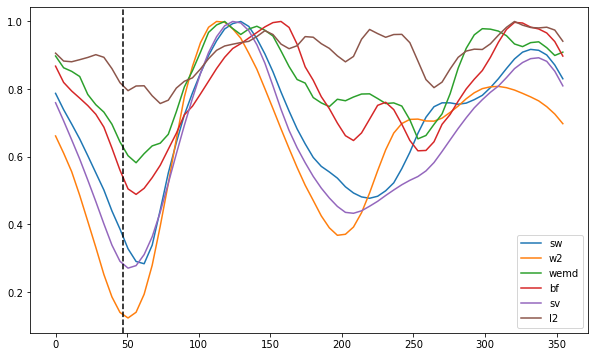

In [11]:
idx = 1

plt.figure(figsize=(10,6))
plt.plot(angles, dists_dict_sw[idx] / np.amax(dists_dict_sw[idx]), label='sw')
plt.plot(angles, dists_dict_w2[idx] / np.amax(dists_dict_w2[idx]), label='w2')
plt.plot(angles, dists_dict_wemd[idx] / np.amax(dists_dict_wemd[idx]), label='wemd')
plt.plot(angles, dists_dict_bf[idx] / np.amax(dists_dict_bf[idx]), label='bf')
plt.plot(angles, dists_dict_sv[idx] / np.amax(dists_dict_sv[idx]), label='sv')
plt.plot(angles, dists_dict_l2[idx] / np.amax(dists_dict_l2[idx]), label='l2')
plt.axvline(rotations[idx], 0, 1, color='k', linestyle='--')
plt.legend()
plt.show()